## Data Preprocessing


In [350]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from scripts.geopy import merge_geodata
from scripts.geopy import get_geodata
from scripts.geopy import load_geodata
from scripts.date_pyler import applier_cwise
from scripts.date_pyler import to_date
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/Train.csv")
df = df.set_index("ID")


## Geodata


In [2]:
# add geodata to dataframe
df_geo = load_geodata(df)


## Date data type convertion


In [3]:
# columnwise datetype conversion on dataframe
date_order = [
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d"],
]
applier_cwise(df_geo, ["STD", "STA", "DATOP"], to_date, orders=date_order)


df_geo["date_dep_year"] = df_geo.DATOP.dt.year.astype(int)
df_geo["date_dep_month"] = df_geo.DATOP.dt.month.astype(int)
df_geo["date_dep_day_year"] = df_geo.DATOP.dt.day_of_year.astype(int)
df_geo["date_dep_day_week"] = df_geo.DATOP.dt.day_of_week.astype(int)
df_geo["date_dep_hour"] = df_geo.STD.dt.hour.astype(int)
df_geo["date_dep_minute"] = df_geo.STD.dt.minute.astype(int)
df_geo["flight_duration"] = (
    (df_geo.STA - df_geo.STD).astype("timedelta64[m]").astype(int)
)
df_geo["min_of_day"] = (df_geo.STD.dt.hour * 60 + df_geo.STD.dt.minute).astype(int)


## FLIGHT STATUS


<AxesSubplot:xlabel='STATUS', ylabel='target'>

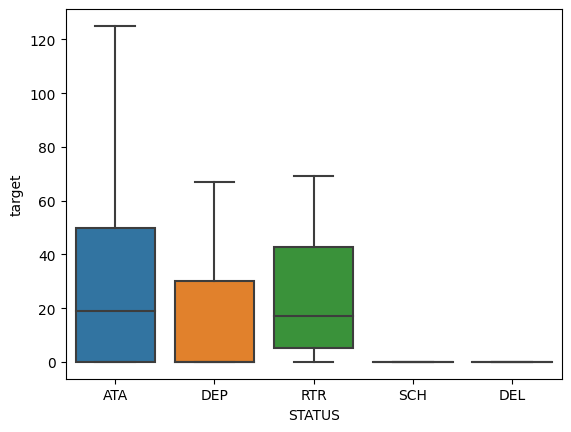

In [4]:
df_geo.STATUS.unique()


sns.boxplot(data=df_geo, x="STATUS", y="target", showfliers=False)


## FLIGHT ID


### Airlines from Flight ID


In [5]:
df_geo["exec_airline"] = df_geo.FLTID.str.split().str[0]
# df_geo[df_geo.exec_airline != df_geo.owner_airline]
df_geo.exec_airline.value_counts()

TU     92443
UG      9434
WKL     3105
AOG     1103
AT       874
INT      282
A        251
SGT      227
20M       29
C         24
PRO       23
GJT       22
6YE        6
DAT        3
D4         2
UH         2
12Y        1
AUI        1
X9         1
Name: exec_airline, dtype: int64

## Feature selection


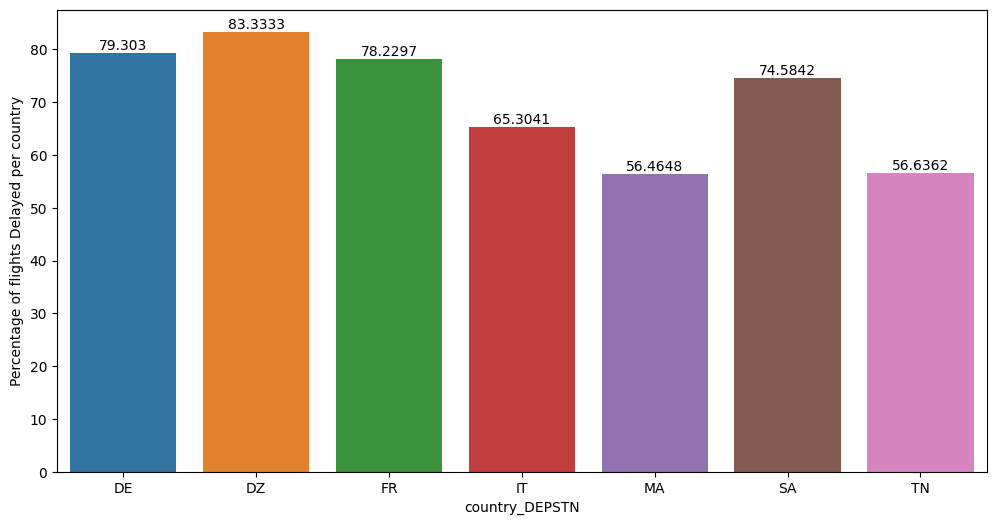

In [365]:
df_grouped_wo0 = df_geo[df_geo.target > 0].groupby("country_DEPSTN").size()
df_grouped = df_geo.groupby("country_DEPSTN").size()
countries = df_grouped[df_grouped > 1500].index.tolist()
percentages_delayed = df_grouped_wo0[countries] / df_grouped[countries]

percentages_delayed = percentages_delayed.dropna()

import seaborn as sns
from matplotlib import pyplot as plt

plt.subplots(figsize=(12, 6))
ax = sns.barplot(percentages_delayed.index, percentages_delayed.values * 100)
plt.ylabel("Percentage of flights Delayed per country")
ax.bar_label(ax.containers[0])
plt.show()

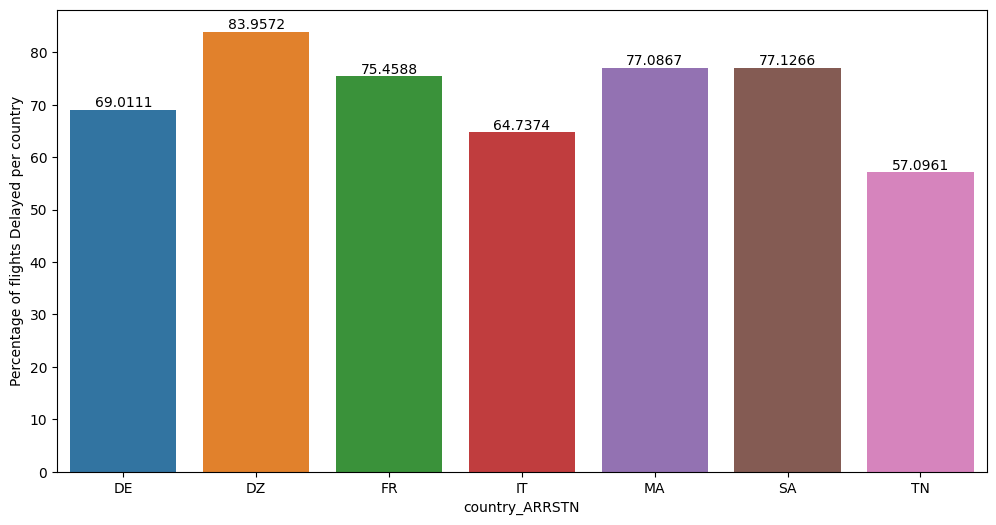

In [364]:
df_grouped_wo0 = df_geo[df_geo.target > 0].groupby("country_ARRSTN").size()
df_grouped = df_geo.groupby("country_ARRSTN").size()
countries = df_grouped[df_grouped > 1500].index.tolist()
percentages_delayed = df_grouped_wo0[countries] / df_grouped[countries]

percentages_delayed = percentages_delayed.dropna()

import seaborn as sns
from matplotlib import pyplot as plt

plt.subplots(figsize=(12, 6))
ax = sns.barplot(percentages_delayed.index, percentages_delayed.values * 100)
plt.ylabel("Percentage of flights Delayed per country")
ax.bar_label(ax.containers[0])
plt.show()

In [321]:
df_geo = df_geo.dropna()


In [322]:
features = [
    "date_dep_year",
    "date_dep_month",
    "date_dep_day_year",
    "date_dep_day_week",
    "date_dep_hour",
    "date_dep_minute",
    "flight_duration",
    "lat_DEPSTN",
    "lon_DEPSTN",
    "elevation_DEPSTN",
    "lat_ARRSTN",
    "lon_ARRSTN",
    "elevation_ARRSTN",
    "exec_airline",
    "STATUS",
]

X = df_geo[features]
y = df_geo.target


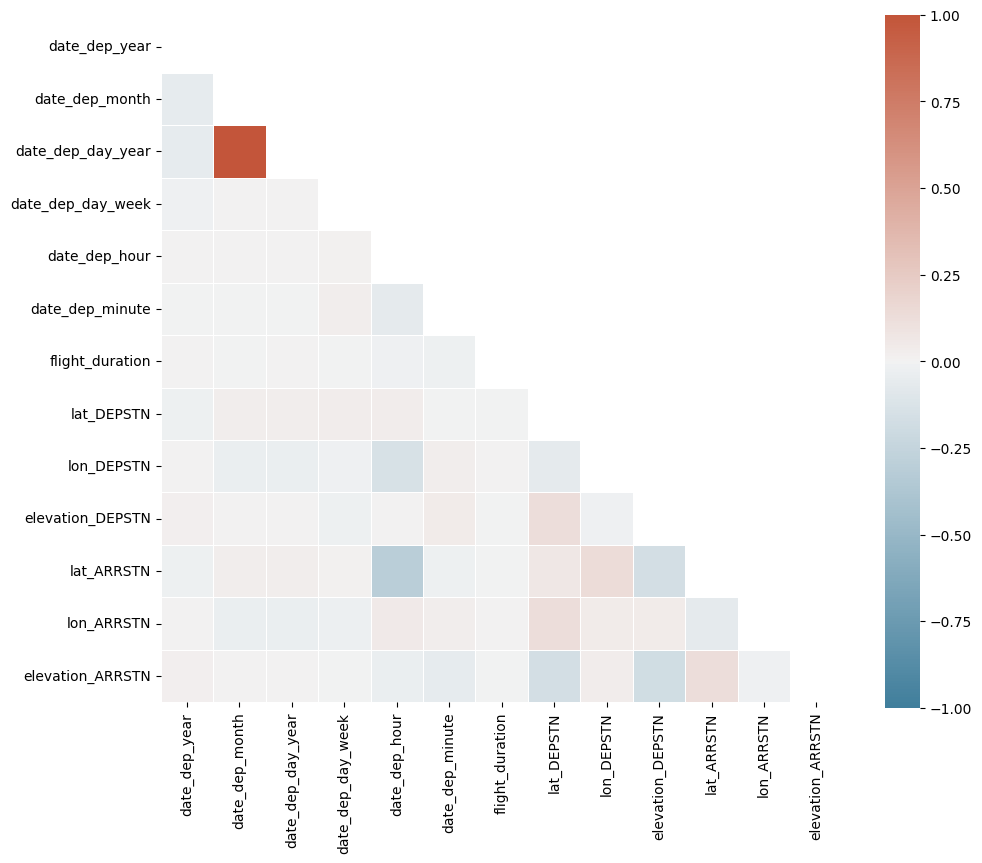

In [329]:
from matplotlib import pyplot as plt

# correlation
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr[abs(corr) > 0.0000001],
    mask=mask,
    cmap=cmap,
    vmax=1,
    center=0,
    vmin=-1,
    square=True,
    linewidths=0.5,
)  # cbar_kws={"shrink": .5})
plt.show()

In [330]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


def OneHot(
    X_train=X_train,
    X_test=X_test,
    column="STATUS",
    drop="first",
    handle_unknown="ignore",
    sparse=False,
):
    onehot = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

    STATUS_onehot_train = onehot.fit_transform(
        X_train[column].to_numpy().reshape(-1, 1)
    )
    STATUS_onehot_df_train = pd.DataFrame(
        STATUS_onehot_train,
        columns=[column + "_" + x for x in onehot.categories_[0][1:]],
    )

    STATUS_onehot_test = onehot.transform(X_test[column].to_numpy().reshape(-1, 1))
    STATUS_onehot_df_test = pd.DataFrame(
        STATUS_onehot_test,
        columns=[column + "_" + x for x in onehot.categories_[0][1:]],
    )

    X_train = pd.concat(
        [X_train, STATUS_onehot_df_train.set_index(X_train.index)], axis=1
    )
    X_test = pd.concat([X_test, STATUS_onehot_df_test.set_index(X_test.index)], axis=1)

    X_train.drop(column, axis=1, inplace=True)
    X_test.drop(column, axis=1, inplace=True)
    return X_train, X_test

In [331]:
X_train, X_test = OneHot(X_train=X_train, X_test=X_test, column="STATUS")
X_train, X_test = OneHot(X_train=X_train, X_test=X_test, column="exec_airline")

/Users/louiskrause/neuefische/Flight_Delay_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [332]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [333]:
lin_reg = LinearRegression()

In [334]:
lin_reg.fit(X_train, y_train)


LinearRegression()

In [335]:
print(
    *sorted(list(zip(X_train.columns.tolist(), lin_reg.coef_)), key=lambda x: x[1]),
    sep="\n"
)

('exec_airline_X9', -119.08252259835925)
('exec_airline_D4', -98.97316536123387)
('exec_airline_GJT', -88.4200576570846)
('exec_airline_WKL', -56.29706030403282)
('STATUS_DEL', -55.159135018233634)
('exec_airline_INT', -54.45930814310364)
('STATUS_SCH', -52.366680045664346)
('exec_airline_AT', -50.266224393767516)
('exec_airline_PRO', -47.749277657044246)
('exec_airline_UG', -46.568998632654676)
('exec_airline_AOG', -45.57157555712801)
('exec_airline_UH', -44.61230736890794)
('lat_DEPSTN', -42.00113403298834)
('exec_airline_TU', -41.21791867847907)
('exec_airline_SGT', -39.22621301567479)
('exec_airline_C', -37.79765469205008)
('exec_airline_A', -36.98251868140819)
('exec_airline_20M', -26.75747624993885)
('exec_airline_6YE', -21.791807439203634)
('lat_ARRSTN', -11.184400476014359)
('elevation_ARRSTN', -4.897957085988939)
('STATUS_DEP', -4.535644297636273)
('date_dep_day_year', -1.9465506142992013)
('STATUS_RTR', 8.477007696447364)
('date_dep_day_week', 9.942302500227887)
('date_dep_mo

In [336]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)
y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)

y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)


In [337]:
rmse_linreg_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_linreg_test = r2_score(y_test, y_test_pred)
rmse_linreg_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_linreg_train = r2_score(y_train, y_train_pred)

In [338]:
print("LINREGSCORES")
print("TRAIN SCORE")
print(f"RMSE: {rmse_linreg_train}")
print(f"r2: {r2_linreg_train}")
print()
print("TEST SCORE")
print(f"RMSE: {rmse_linreg_test}")
print(f"r2: {r2_linreg_test}")

LINREGSCORES
TRAIN SCORE
RMSE: 115.49382905759576
r2: 0.04511417765506298

TEST SCORE
RMSE: 109.09877643112753
r2: 0.04452840560435867


In [339]:
from xgboost import XGBRegressor
import random

params = {
    "subsample": 1,
    "n_estimators": 1000,
    "min_child_weight": 2,
    "max_depth": 4,
    "learning_rate": 0.2,
    "gamma": 0.1,
    "colsample_bytree": 0.75,
}
xgb_model = XGBRegressor(**params)


y_train = np.where(y_train > 1440 / 2, y_train / 2, y_train)
feat_train = X_train.drop(columns="date_dep_month")
tar_train = y_train
feat_test = X_test.drop(columns="date_dep_month")
tar_test = y_test


xgb_model.fit(feat_train, tar_train)

y_test_pred = xgb_model.predict(feat_test)
y_train_pred = xgb_model.predict(feat_train)

y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)

y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)

rmse_xgb_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_xgb_test = r2_score(y_test, y_test_pred)
mae_xgb_test = mean_absolute_error(y_test, y_test_pred)
mape_xgb_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_xgb_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_xgb_train = r2_score(y_train, y_train_pred)
mae_xgb_train = mean_absolute_error(y_train, y_train_pred)
mape_xgb_train = mean_absolute_percentage_error(y_train, y_train_pred)

/Users/louiskrause/neuefische/Flight_Delay_Prediction/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


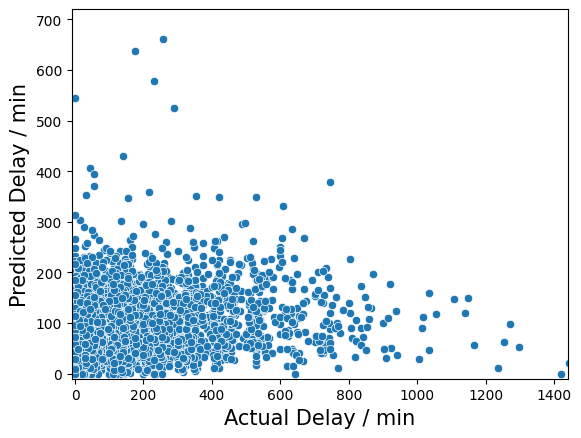

In [340]:
from matplotlib import pyplot as plt

sns.scatterplot(y_test, y_test_pred)
plt.ylim(-10, 720)
plt.xlim(-10, 1440)
plt.xlabel("Actual Delay / min", fontsize=15)
plt.ylabel("Predicted Delay / min", fontsize=15)
plt.show()

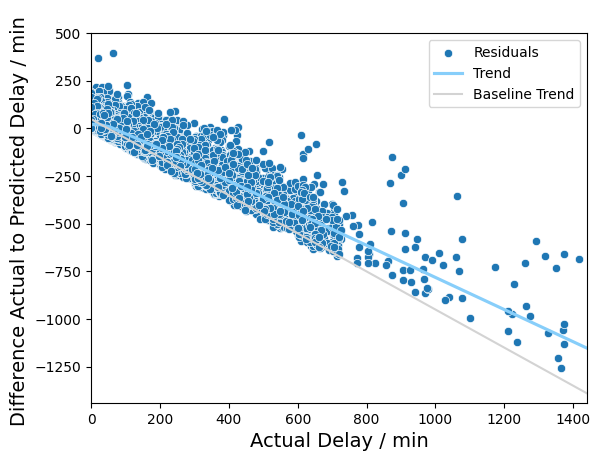

In [342]:
fig, ax = plt.subplots()
# ax.hlines(y=0, xmin=-500, xmax=3500, linewidth=0.5, color='k')
sns.scatterplot(ax=ax, x=y_train, y=(y_train_pred - y_train))
p1 = sns.regplot(
    ax=ax,
    x=y_train,
    y=(y_train_pred - y_train),
    scatter=False,
    x_ci=None,
    lowess=True,
    color="lightskyblue",
)

x = np.linspace(-100, 5000, 1000)
y = -x + 49
p2 = ax.plot(x, y, "-", color="lightgrey")
plt.xlim(0, 1440)
plt.ylim(-1440, 500)
plt.legend(["Residuals", "Trend", "Baseline Trend"])
plt.xlabel("Actual Delay / min", fontsize=14)
plt.ylabel("Difference Actual to Predicted Delay / min ", fontsize=14)
plt.show()

In [343]:
print("XGB Scores ")
print("TRAIN SCORE")
print(f"RMSE: {rmse_xgb_train}")
print(f"r2: {r2_xgb_train}")
print(f"MAE: {mae_xgb_train}")
print(f"MAPE: {mape_xgb_train}")
print()
print("TEST SCORE")
print(f"RMSE: {rmse_xgb_test}")
print(f"r2: {r2_xgb_test}")
print(f"MAE: {mae_xgb_test}")
print(f"MAPE: {mape_xgb_test}")

XGB Scores 
TRAIN SCORE
RMSE: 76.06113260220971
r2: 0.34495260341916334
MAE: 40.6613418578636
MAPE: 3.3471517315303904e+16

TEST SCORE
RMSE: 102.05627900039647
r2: 0.16390143115784306
MAE: 46.167143685963524
MAPE: 3.756301651286294e+16


In [344]:
print(
    *sorted(
        list(zip(feat_train.columns.tolist(), xgb_model.feature_importances_)),
        key=lambda x: x[1],
        reverse=True,
    ),
    sep="\n"
)

('exec_airline_WKL', 0.28969115)
('STATUS_SCH', 0.2100651)
('exec_airline_TU', 0.104607165)
('exec_airline_UG', 0.08751089)
('date_dep_year', 0.038836982)
('date_dep_hour', 0.033553936)
('date_dep_day_year', 0.02501)
('lon_DEPSTN', 0.019638149)
('elevation_ARRSTN', 0.01829619)
('elevation_DEPSTN', 0.01822934)
('flight_duration', 0.018187728)
('lat_DEPSTN', 0.017219968)
('date_dep_day_week', 0.017089177)
('lon_ARRSTN', 0.015832003)
('lat_ARRSTN', 0.0147871)
('exec_airline_AT', 0.014373898)
('date_dep_minute', 0.013923059)
('STATUS_DEP', 0.013222237)
('STATUS_RTR', 0.010145769)
('STATUS_DEL', 0.0061108484)
('exec_airline_DAT', 0.00593423)
('exec_airline_GJT', 0.002013125)
('exec_airline_INT', 0.0019933544)
('exec_airline_D4', 0.001477414)
('exec_airline_AOG', 0.0012808018)
('exec_airline_A', 0.00050345465)
('exec_airline_PRO', 0.00017122494)
('exec_airline_6YE', 0.0001574714)
('exec_airline_SGT', 0.00013826237)
('exec_airline_20M', 0.0)
('exec_airline_C', 0.0)
('exec_airline_UH', 0.0)
('

In [346]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


y_test_pred_bool = np.where(y_test_pred > 0, 1, 0)
y_test_bool = np.where(y_test > 0, 1, 0)

print(classification_report(y_test_bool, y_test_pred_bool))
confusion_matrix(y_test_bool, y_test_pred_bool)

              precision    recall  f1-score   support

           0       0.85      0.26      0.39      9475
           1       0.71      0.98      0.82     17318

    accuracy                           0.72     26793
   macro avg       0.78      0.62      0.61     26793
weighted avg       0.76      0.72      0.67     26793



array([[ 2426,  7049],
       [  423, 16895]])

### Grid search with xgb


In [74]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [3, 4],
    "learning_rate": [0.2, 0.3],
    "colsample_bytree": [1, 0.75],
    "subsample": [1, 0.75],
    "gamma": [0, 0.1],
    "min_child_weight": [1.2],
}

estimator = XGBRegressor()

gs = RandomizedSearchCV(
    estimator,
    param_grid,
    n_jobs=6,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=5,
    n_iter=30,
)

In [75]:
gs.fit(feat_train, tar_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 3/3] END colsample_bytree=0.75, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=500, subsample=0.75;, score=-92.437 total time=  17.2s
[CV 2/3] END colsample_bytree=0.75, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=500, subsample=0.75;, score=-94.628 total time=  17.2s
[CV 1/3] END colsample_bytree=0.75, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=500, subsample=0.75;, score=-92.961 total time=  17.3s
[CV 1/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=500, subsample=1;, score=-92.382 total time=  18.7s
[CV 2/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=500, subsample=1;, score=-93.895 total time=  18.8s
[CV 3/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1.2, n_estimators=5

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          n_estimators=100, n_jobs=None,
                                 

In [107]:
y_test_pred = gs.best_estimator_.predict(feat_test)
y_train_pred = gs.best_estimator_.predict(feat_train)

y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)

y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)

rmse_xgb_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_xgb_test = r2_score(y_test, y_test_pred)
rmse_xgb_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_xgb_train = r2_score(y_train, y_train_pred)

In [108]:
print("XGB Scores ")
print("TRAIN SCORE")
print(f"RMSE: {rmse_xgb_train}")
print(f"r2: {r2_xgb_train}")
print()
print("TEST SCORE")
print(f"RMSE: {rmse_xgb_test}")
print(f"r2: {r2_xgb_test}")

XGB Scores 
TRAIN SCORE
RMSE: 85.98845713858911
r2: 0.27480100504534544

TEST SCORE
RMSE: 102.78340802311956
r2: 0.15194494394982105


In [78]:
gs.best_params_


{'subsample': 1,
 'n_estimators': 500,
 'min_child_weight': 1.2,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.75}